In [1]:
# common imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re as re
import seaborn as sns
np.random.seed(28)

### Load Data and Exploration Analysis

In [56]:
titanic = pd.read_csv("train.csv")

In [57]:
titanic.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [58]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Features with missing values:
Age(Train, Test), Cabin(Train, Test), Embarked(Train), Fare(Test)

In [59]:
titanic["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [60]:
titanic["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [61]:
# encode categorical attributes
titanic["Sex_enc"] = titanic["Sex"].map({"female":1, "male": 0}) # encode sex
titanic["Embarked_enc"] = titanic["Embarked"].map({"S":0, "C":1, "Q":2}) # encode Embarked

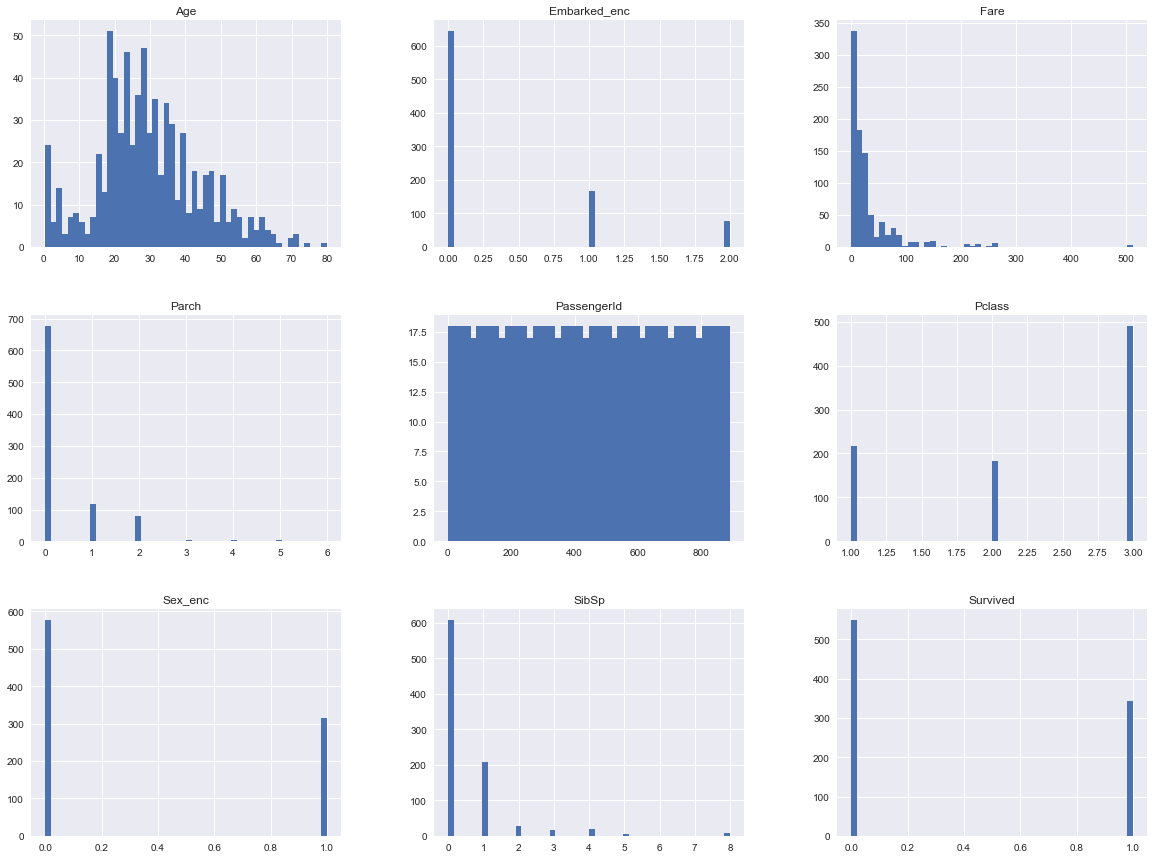

In [62]:
# Take a look at the distribution of all feature values
%matplotlib inline
titanic.hist(bins=50, figsize=(20,15))
plt.show()

A few observations: 
* Attributes have very different scales - need to be standardized
* Sex, Embarked, Parch, Pclass and SibSp take discrete distributions, Age and Fare take continuous distributions
* Name, Ticket, Cabin are not plotted

#### Sex, Pclass, Parch, SibSp, Embarked

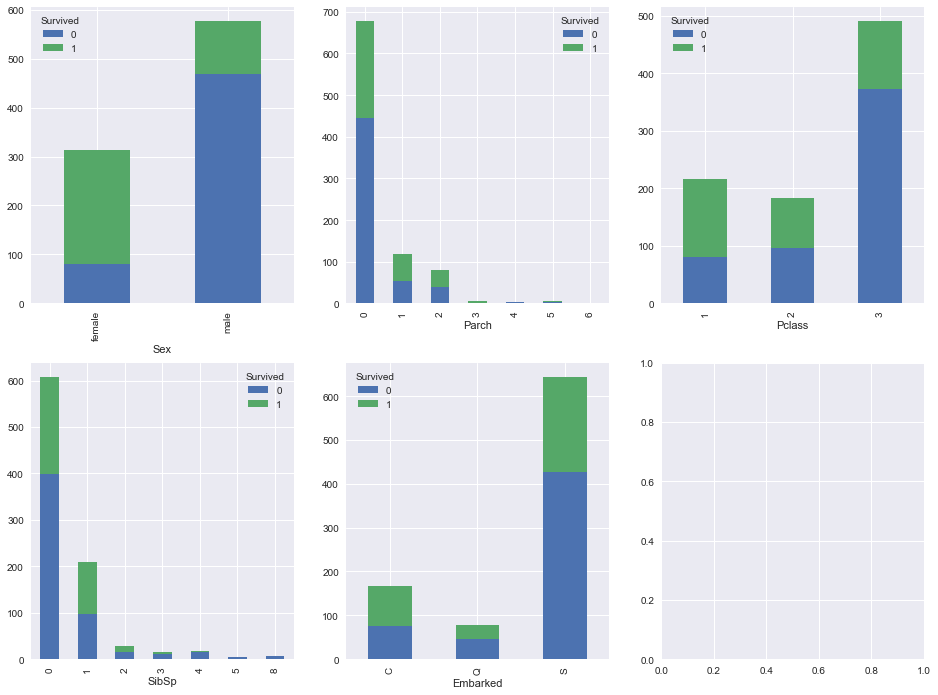

In [63]:
# Take a look at how Embarked, Parch, Pclass, SibSp and Sex are associated with Survived
fig, axes = plt.subplots(2,3, figsize=(16,12))
attr_ls = ["Sex", "Parch", "Pclass", "SibSp", "Embarked"]
for attr, ax in zip(attr_ls[:3], axes[0]):
    titanic.pivot_table("PassengerId", attr, "Survived", "count").plot(kind="bar", stacked=True, ax=ax)
for attr, ax in zip(attr_ls[3:], axes[1]):
    titanic.pivot_table("PassengerId", attr, "Survived", "count").plot(kind="bar", stacked=True, ax=ax) 

* Female is more likely to survive than male
* Parch seems not to be a significant factor
* Passengers in the third class are more likely to perish
* SibSp seems not be a siginificant factor
* Passengers who embarked at S are more likely to perish

In [64]:
# let's verify the observations with correlation matrix
corr = titanic[["Survived", "Sex_enc", "Parch", "Pclass", "SibSp", "Embarked_enc"]].corr()
np.abs(corr["Survived"]).sort_values(ascending=False)

Survived        1.000000
Sex_enc         0.543351
Pclass          0.338481
Embarked_enc    0.108669
Parch           0.081629
SibSp           0.035322
Name: Survived, dtype: float64

In [65]:
# what about combining SibSp and Parch
titanic["family_size"] = titanic["Parch"] + titanic["SibSp"]
titanic[["Survived", "family_size"]].corr()["Survived"]

Survived       1.000000
family_size    0.016639
Name: Survived, dtype: float64

In [66]:
# family size is not more correlated than Parch and SibSp, so delete it
titanic.drop("family_size", axis=1, inplace=True)

#### Age and Fare

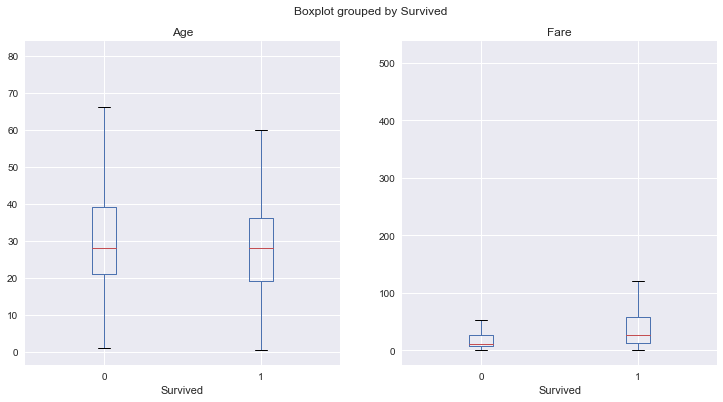

In [67]:
# take a look at the numeric features Age, Fare
fig, axes = plt.subplots(1,2,figsize=(12,6))
titanic.boxplot(by="Survived", column="Age", ax=axes[0])
titanic.boxplot(by="Survived", column="Fare", ax=axes[1])
plt.show()

* Survived passengeres are slightly younger than those perished
* The fares of Survived passengers have higher value than that of perished passengeres

In [68]:
# still take a look at the correlation
titanic[["Survived", "Fare", "Age"]].corr()["Survived"]

Survived    1.000000
Fare        0.257307
Age        -0.077221
Name: Survived, dtype: float64

#### Title, Ticket and Cabin

In [69]:
# Extract title from Name
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""
non_rare = ["Mr", "Miss", "Mrs", "Master"] # non rare titles
title = titanic["Name"].map(get_title)
title = np.where(title.isin(non_rare), title, "Rare")
titanic["Title"] = title

In [70]:
titanic["Title"].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Rare       27
Name: Title, dtype: int64

In [98]:
def extract_cabin(cabin):
    split = re.split("\s", cabin)        
    cabin_letter = [s[0] for s in split]
    if len(set(cabin_letter)) == 1: # if the elements in the list are the same, 
        return cabin_letter[0] # return the element
    else:
        return "M" # otherwise return "M"
titanic["Cabin_letter"] = titanic["Cabin"].map(lambda x: "U" if pd.isnull(x) else extract_cabin(x))

In [99]:
titanic["Cabin_letter"].value_counts()

U    687
C     59
B     47
D     33
E     32
A     15
F      9
M      4
G      4
T      1
Name: Cabin_letter, dtype: int64

In [100]:
def ticket_len(ticket):
    split = re.split("\s", ticket)
    return len(split[-1])
titanic["Ticket_len"] = titanic["Ticket"].map(ticket_len)
titanic["Ticket_len"].value_counts()

6    423
5    246
4    169
7     44
3      7
1      2
Name: Ticket_len, dtype: int64

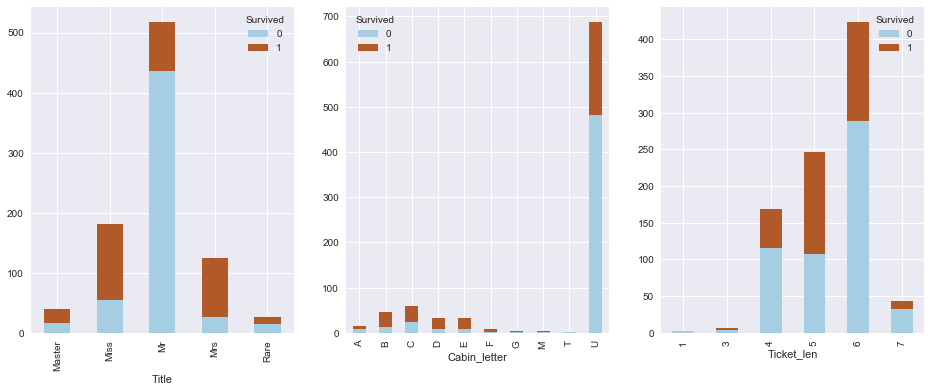

In [101]:
# lets plot Title, Cabin_letter and Ticket_len
fig, axes = plt.subplots(1,3,  figsize=(16, 6))
attr_ls = ["Title", "Cabin_letter", "Ticket_len"]
for ax, attr in zip(axes, attr_ls):
    titanic.pivot_table("PassengerId", attr, "Survived", "count").plot(kind="bar", stacked=True, colormap="Paired", ax=ax)

* Mrs are more likely to perish, which is consistent with the previous analysis that males are more possible to perish
* Cabins seems not to be an important feature
* Ticket length seems not to be an important feature

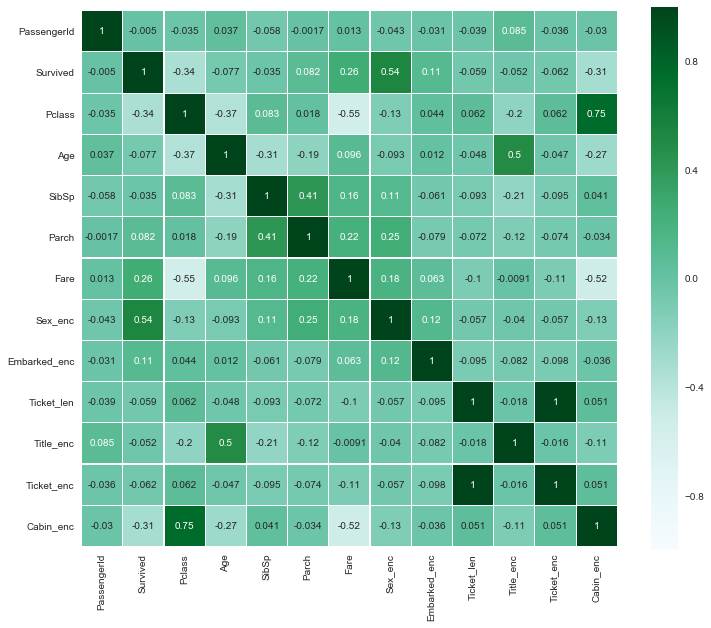

In [102]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
titanic["Title_enc"] = encoder.fit_transform(titanic["Title"])
titanic["Ticket_enc"] = encoder.fit_transform(titanic["Ticket_len"])
titanic["Cabin_enc"] = encoder.fit_transform(titanic["Cabin_letter"])
corr = titanic.corr()
fig = plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='BuGn', linewidths=0.1,vmax=1.0, square=True, annot=True)
plt.show()

* The features are that highly corrected with Survived include Pclass, Fare, Sex_enc, Cabin_enc
* Title is another important feature but since it is categorical, it is not linearly correlated with Survived
* Cabin_enc and Pclass are highly correlated, maybe we can fill the missing values in Cabin with Pclass

### Prepare Data through Pipeline
We need to complete following steps through a pipeline
* Extract Title from Name
* Extract Cabin letter from Cabin
* Encode categorical features
* Fill missing values
* Standardize numeric features

In [103]:
# defined an estimator to pick attributes
from sklearn.base import BaseEstimator, TransformerMixin
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attrib):
        self.attrib = attrib
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.attrib].values

In [104]:
# define a customize binarizer to binarize categorical features (LabelBinarizer() doesn't work with pipeline())
from sklearn.preprocessing import LabelBinarizer
class CustomBinarizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None,**fit_params):
        return self
    def transform(self, X):
        return LabelBinarizer().fit(X).transform(X)

In [105]:
# label_binarize accepts pre-defined classes
from sklearn.preprocessing import label_binarize
class BinarizerByClass(BaseEstimator, TransformerMixin):
    def __init__(self, classes):
        self.classes = classes
    def fit(self, X, y=None, **fit_params):
        return self
    def transform(self, X):
        return label_binarize(X, classes = self.classes)

In [110]:
class FeatureAdder(BaseEstimator, TransformerMixin):
    def __init__(self, name_attr, cabin_attr):
        self.name_attr = name_attr
        self.cabin_attr = cabin_attr
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        title = X[self.name_attr].map(get_title)
        non_rare = ["Mr", "Miss", "Mrs", "Master"] # non rare titles
        title = np.where(title.isin(non_rare), title, "Rare")
        cabin_letter = X[self.cabin_attr].map(lambda x: "U" if pd.isnull(x) else extract_cabin(x)).values
        return np.c_[X, title, cabin_letter] # append the added columns 

In [120]:
# fill the missing values by mode
class FillingByMode(BaseEstimator, TransformerMixin):
    def __init__(self, attr):
        self.attr = attr
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X[self.attr].fillna(X[self.attr].mode()[0], inplace=True)
        return X

In [122]:
titanic = pd.read_csv("train.csv")
target = titanic["Survived"]
titanic_test = pd.read_csv("test.csv")

In [123]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer

featureAdder = FeatureAdder("Name", "Cabin")
titanic = pd.DataFrame(featureAdder.fit_transform(titanic), columns=list(titanic.columns)+["Title", "Cabin_letter"])
titanic.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Cabin_letter
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,NaN,S,Mr,U
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,Mrs,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,NaN,S,Miss,U


In [125]:
cat_pip = FeatureUnion(transformer_list= [
    ("sex_transform", Pipeline([("selector", DataFrameSelector(["Sex"])),
                                ("binarizer", CustomBinarizer())])),  # binarize Sex
    ("embarked_transform", Pipeline([("filling", FillingByMode("Embarked")),
                                     ("selector", DataFrameSelector(["Embarked"])),
                                    ("binarizer", CustomBinarizer())])), # encode Embarked
    ("title_transform", Pipeline([("selector", DataFrameSelector(["Title"])),
                                    ("binarizer", CustomBinarizer())])), # encode Title
    ("cabin_transform", Pipeline([("selector", DataFrameSelector(["Cabin_letter"])),
                                ("binarizer", BinarizerByClass(list(set(titanic["Cabin_letter"]))))])) # encode Cabin Letter
])
cat_pip.fit_transform(titanic)

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0]])

In [126]:
num_attribs = ["Age", "Fare", "Parch", "SibSp"]
num_pip = Pipeline([
    ("selector", DataFrameSelector(num_attribs)),
    ("imputer", Imputer(strategy="mean")),
    ("std_scaler", StandardScaler())
])

In [127]:
full_pip = FeatureUnion(transformer_list=[
    ("cat_pip", cat_pip),
    ("num_pip", num_pip)
])

In [128]:
prepared_data = full_pip.fit_transform(titanic)
prepared_data = np.c_[titanic["Pclass"].values, prepared_data]
prepared_data.shape

(891, 24)

### Train Models

In [129]:
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedShuffleSplit
from sklearn.metrics import recall_score, accuracy_score
classifier = [RandomForestClassifier(), 
       GradientBoostingClassifier(), 
       SVC(), 
       LogisticRegression()]

In [130]:
k = 5
split = StratifiedKFold(n_splits=k)
accuracy = {}

for train_index, test_index in split.split(prepared_data, target):
    X_train, Y_train = prepared_data[train_index], target[train_index]
    X_test, Y_test = prepared_data[test_index], target[test_index]

    for clf in classifier:
        name = clf.__class__.__name__
        clf.fit(X_train, Y_train)
        Y_prediction = clf.predict(X_test)
        accu = accuracy_score(y_pred=Y_prediction, y_true=Y_test)

        if name in accuracy:
            accuracy[name] += accu
        else:
            accuracy[name] = accu
                
print("Accuracy:")
for key, value in accuracy.items():
    print(key, ": ",  value/k)

Accuracy:
RandomForestClassifier :  0.799181853097
GradientBoostingClassifier :  0.829488042891
SVC :  0.832795987782
LogisticRegression :  0.829437684478


In [131]:
from sklearn.ensemble import VotingClassifier
grb_clf = GradientBoostingClassifier()
svc_clf = SVC(probability=True)
lgs_clf = LogisticRegression()
voting = VotingClassifier(estimators=[("grb", grb_clf), ("svc", svc_clf), ("lgs", lgs_clf)], voting = "soft")
accu = []
for train_index, test_index in split.split(prepared_data, target):
    train_X, train_Y = prepared_data[train_index], target[train_index]
    test_X, test_Y = prepared_data[test_index], target[test_index]
    voting.fit(train_X, train_Y)
    pred_Y = voting.predict(test_X)
    accu.append(accuracy_score(y_pred=pred_Y, y_true=test_Y))
print("Accuracy", np.array(accu).mean())

Accuracy 0.838439215444


In [140]:
from sklearn.model_selection import GridSearchCV
param_grid = {"learning_rate": np.linspace(0.1,1,10), 
              "n_estimators": np.arange(50,500,50), 
              "max_depth": [3,5,10]}
grid_search = GridSearchCV(GradientBoostingClassifier(),param_grid,cv=5,n_jobs=-1,verbose=4, scoring="accuracy")
grid_search.fit(prepared_data, target)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1193 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:  4.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'learning_rate': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]), 'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450]), 'max_depth': [3, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=4)

In [145]:
gb_clf = grid_search.best_estimator_

In [147]:
param_grid = {"n_estimators": np.arange(50,500,50),
             "max_depth": [3,5,10,15],
             "max_features": np.arange(1, prepared_data.shape[1], 3),
             "bootstrap": [True, False]}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(prepared_data, target)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450]), 'max_depth': [3, 5, 10, 15], 'max_features': array([ 1,  4,  7, 10, 13, 16, 19, 22]), 'bootstrap': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [152]:
forest_clf = grid_search.best_estimator_
grid_search.best_score_

0.83838383838383834

In [170]:
from sklearn.svm import SVC
param_grid = {"kernel": ["linear", "rbf"], 
              "C": np.arange(1.0, 200.0, 20), 
              "gamma":np.arange(0.01, 3.0, 0.5)}
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=4)
grid_search.fit(prepared_data, target)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 236 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 378 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 549 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'kernel': ['linear', 'rbf'], 'C': array([   1.,   21.,   41.,   61.,   81.,  101.,  121.,  141.,  161.,  181.]), 'gamma': array([ 0.01,  0.51,  1.01,  1.51,  2.01,  2.51])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=4)

In [171]:
grid_search.best_score_

0.83277216610549942

In [182]:
svc_clf = grid_search.best_estimator_
svc_clf.set_params(probability =True)

SVC(C=21.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [185]:
from sklearn.ensemble import VotingClassifier

voting = VotingClassifier(estimators=[("grb", gb_clf), 
                                      ("forest", forest_clf), 
                                      ("svc", svc_clf)], voting = "soft")
accu = []
for train_index, test_index in split.split(prepared_data, target):
    train_X, train_Y = prepared_data[train_index], target[train_index]
    test_X, test_Y = prepared_data[test_index], target[test_index]
    voting.fit(train_X, train_Y)
    pred_Y = voting.predict(test_X)
    accu.append(accuracy_score(y_pred=pred_Y, y_true=test_Y))
print("Accuracy", np.array(accu).mean())

Accuracy 0.838407617313


In [186]:
voting.fit(prepared_data, target)

VotingClassifier(estimators=[('grb', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.10000000000000001, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_sampl...',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))],
         n_jobs=1, voting='soft', weights=None)

In [187]:
titanic_test = pd.read_csv("test.csv")

In [188]:
featureAdder = FeatureAdder("Name", "Cabin")
arr = featureAdder.fit_transform(titanic_test)
titanic_test = pd.DataFrame(arr, columns=list(titanic_test.columns)+["Title", "Cabin_letter"])

In [189]:
prepared_test = full_pip.fit_transform(titanic_test)
prepared_test = np.c_[titanic_test["Pclass"].values, prepared_test]
prepared_test.shape

(418, 24)

In [190]:
prediction = voting.predict(prepared_test)

In [191]:
submission = pd.DataFrame({'PassengerId': titanic_test["PassengerId"],
                           'Survived': prediction})

In [192]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [193]:
submission.to_csv("submission.csv", index=False)